# 1a. Filter for high-quality genomes to download

In this notebook, we will use __`pyphylon`__'s `download` and `qcqa` modules to select candidate genomes to download for pangenome generation.

In this example we will select genomes for download from [BV-BRC](https://www.bv-brc.org/)

## Setup

In [1]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

from pyphylon.downloads import download_example_bvbrc_genome_files, get_scaffold_n50_for_species
import pyphylon.qcqa as qcqa

In [2]:
plt.rcParams["figure.dpi"] = 200
sns.set_palette("deep")
sns.set_context("paper")
sns.set_style("whitegrid")

In [3]:
'''
These files are from a fixed date (Oct 23 2023) and meant for generating
reproducible results, as in the case of this example notebook. Use
download_bvbrc_genome_info from pyphylon.dowloads instead for
downloading the most current versions of these files from BV-BRC
'''
download_example_bvbrc_genome_files(output_dir="data/metadata")

2024-05-22 14:09:09,978 - INFO - File genome_metadata_Oct_12_23.tsv already exists in data/metadata and force is set to False. Skipping download.
2024-05-22 14:09:09,979 - INFO - File genome_summary_Oct_12_23.tsv already exists in data/metadata and force is set to False. Skipping download.


In [4]:
summary = pd.read_csv("data/metadata/genome_summary_Oct_12_23.tsv", sep='\t', dtype='object')
metadata = pd.read_csv("data/metadata/genome_metadata_Oct_12_23.tsv", sep='\t', dtype='object')

summary.shape

(793275, 20)

## Example Species: _Streptococcus pyogenes_

In [5]:
SPECIES_NAME = "Streptococcus pyogenes"

# How many strains of the species/genus are available
species_summary = qcqa.filter_by_species(summary, SPECIES_NAME)

display(
    species_summary.shape,
    species_summary.head()
)

(2286, 20)

,genome_id,genome_name,taxon_id,genome_status,genome_length,gc_content,contig_l50,contig_n50,chromosomes,plasmids,contigs,patric_cds,refseq_cds,trna,rrnacoarse_consistency,fine_consistency,checkm_completeness,checkm_contamination,genome_qualitydate_created,date_modified
637179,1314.547,Streptococcus pyogenes,1314,Plasmid,19203,34.39,NaN,NaN,NaN,1,1,25,21,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-30T07:25:44.857Z
637180,1314.540,Streptococcus pyogenes,1314,Plasmid,28975,34.76,NaN,NaN,NaN,1,1,38,35,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-29T17:49:02.717Z
637181,1210041.3,Streptococcus pyogenes 06BA18369,1210041,WGS,1813404,38.4,9,71565,0,0,47,1825,0,30,NaN,99.0,100.0,0.0,NaN,2015-03-16T03:17:09.594Z
637182,1314.4070,Streptococcus pyogenes 1004,1314,Complete,1842099,38.30196,1,1842099,1,0,1,1798,1706,67,NaN,99.9,100.0,0.0,NaN,2023-04-21T00:08:53.590Z
637183,1314.4068,Streptococcus pyogenes 1039,1314,Complete,1856557,38.30591,1,1856557,1,0,1,1827,1734,67,NaN,99.8,100.0,0.0,NaN,2023-04-21T00:00:24.086Z


## Plot unfiltered dataset

In [6]:
# Find the scaffold N50 score of the reference genome for the organism of interest
# Either visit the NCBI website or retrieve it using the following method (~20 seconds)
scaffold_n50 = get_scaffold_n50_for_species(species_summary.taxon_id.mode().values[0])
scaffold_n50

2024-05-22 14:09:16,596 - INFO - Fetching reference genome link for taxon ID 1314
2024-05-22 14:09:16,597 - INFO - ====== WebDriver manager ======
2024-05-22 14:09:16,933 - INFO - Get LATEST chromedriver version for google-chrome
2024-05-22 14:09:17,184 - INFO - Get LATEST chromedriver version for google-chrome
2024-05-22 14:09:17,266 - INFO - Driver [/Users/sidhu/.wdm/drivers/chromedriver/mac64/124.0.6367.207/chromedriver-mac-arm64/chromedriver] found in cache
2024-05-22 14:09:25,087 - INFO - Found reference genome link: /datasets/genome/GCF_900475035.1/
2024-05-22 14:09:25,088 - INFO - Fetching Scaffold N50 value from https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_900475035.1/
2024-05-22 14:09:25,088 - INFO - ====== WebDriver manager ======
2024-05-22 14:09:25,300 - INFO - Get LATEST chromedriver version for google-chrome
2024-05-22 14:09:25,422 - INFO - Get LATEST chromedriver version for google-chrome
2024-05-22 14:09:25,582 - INFO - Driver [/Users/sidhu/.wdm/drivers/chromedriver

1700000

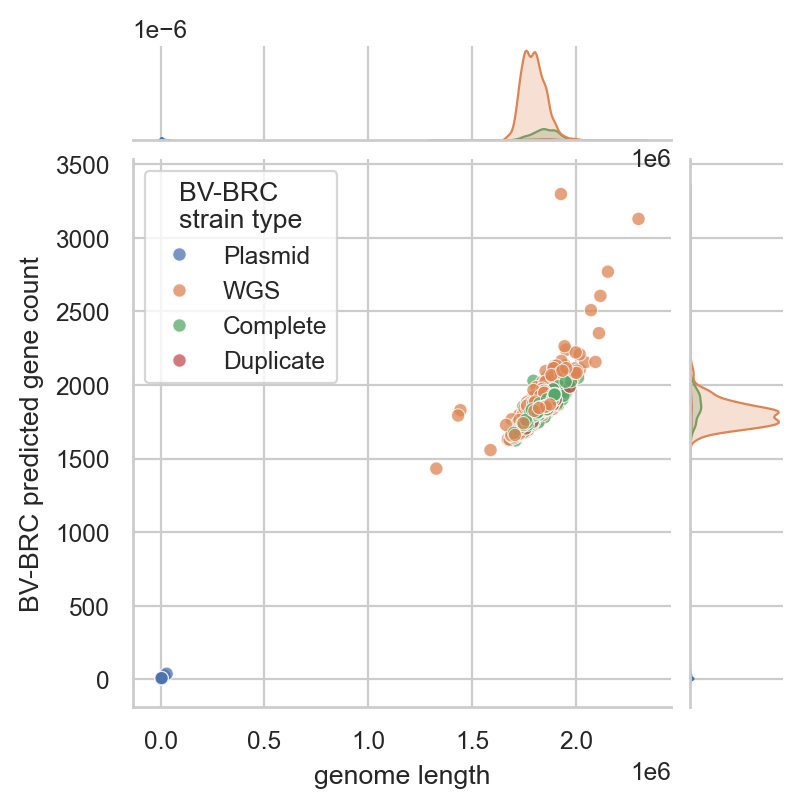

In [7]:
# Initial unfiltered strain plot
h = sns.jointplot(
    data=species_summary,
    x="genome_length",
    y="patric_cds",
    hue="genome_status",
    alpha=0.75,
    height=4
)

h.ax_joint.legend(
    title='BV-BRC\nstrain type',
)

h.ax_joint.set_xlabel("genome length")
h.ax_joint.set_ylabel("BV-BRC predicted gene count")
plt.show()

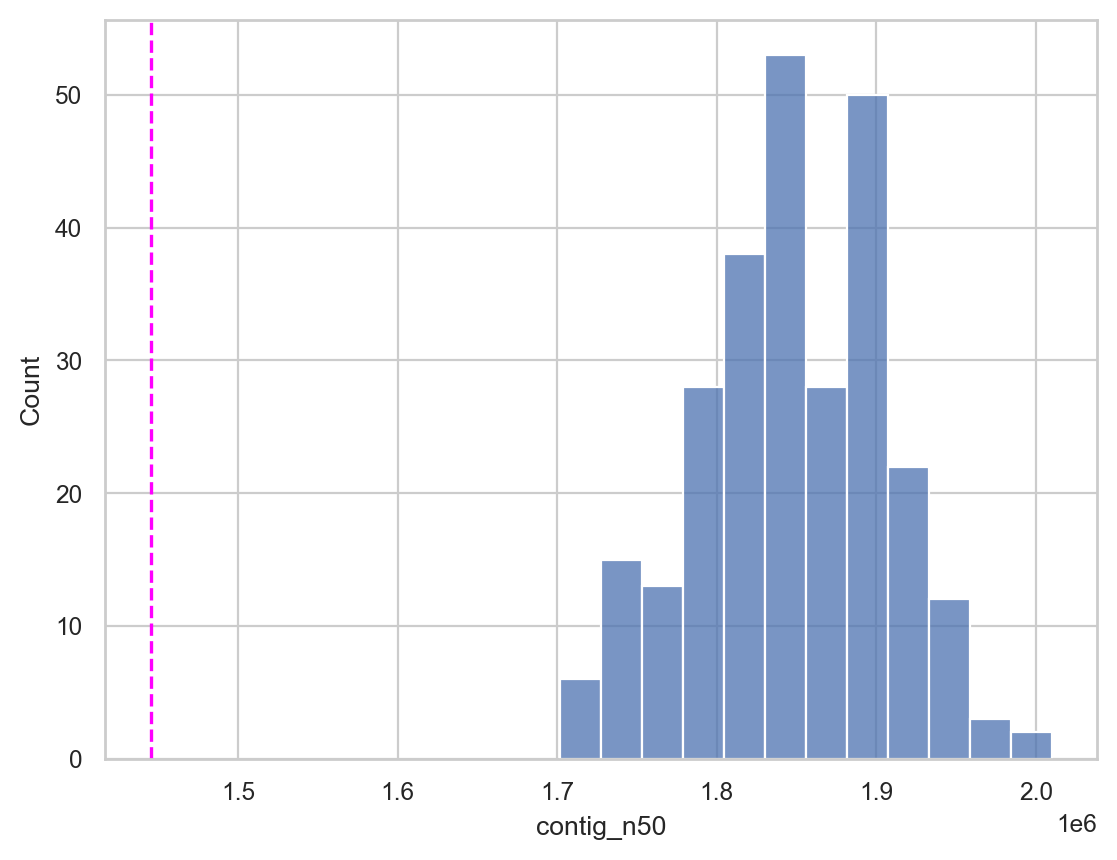

In [8]:
# Find reference strain N50 value from NCBI Genome and multiply by 0.85
# If your species/genus has multiple reference strains, pick the smallest by genome length

# Only applies for Complete sequences
species_complete_summary = species_summary[species_summary.genome_status == 'Complete']

fig, ax = plt.subplots()

# Set threshold as 0.85 * Scaffold N50 score
species_ref_n50 = scaffold_n50
min_thresh_n50 = int(0.85 * species_ref_n50)

# Most (if not all) Complete sequences pass this threshold
sns.histplot(species_complete_summary.contig_n50.dropna().astype('int'), ax=ax)
plt.axvline(x=min_thresh_n50, color='#ff00ff', linestyle='--')

## Initial Filtration Report

In [9]:
# Complete sequences get filtered by their N50 and L50 scores
# Other WGS sequences get filtered by their contig count and CheckM
# contaminaion & completeness metrics
filtered_species_summary, df_filtration = qcqa.filter_by_genome_quality(
    species_summary,
    min_thresh_n50=min_thresh_n50,
    max_contig=None,
    contamination_cutoff=None,
    completeness_cutoff=None,
    return_stats=True,
)

display(
    f'Filtered Strains:',
    filtered_species_summary.shape,
    f'------------------------------',
    f'Filtration Report',
    df_filtration
)

'Filtered Strains:'

(257, 20)

'------------------------------'

'Filtration Report'

,initial,num_filtered,remaining
prefiltration,2286,0,2286
L50/N50,2286,55,2231
contig_count,2231,148,2083
CheckM_completeness_contamination,2083,1826,257


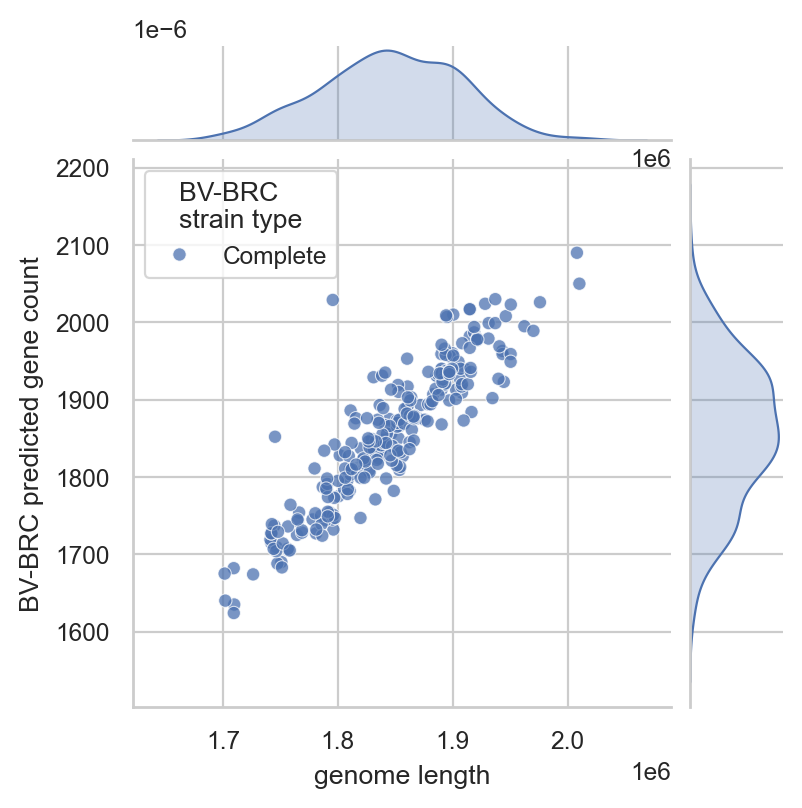

In [10]:
# Same initial plot but with only (first-pass) filtered strains
# For this plot, make sure your WGS sequences form a nice line
# Complete sequences may be all over the place

# For this example, we don't need to filter our data based on the
# distribution we see below

h = sns.jointplot(
    data=filtered_species_summary,
    x="genome_length",
    y="patric_cds",
    hue="genome_status",
    alpha=0.75,
    height=4
)

h.ax_joint.legend(
 title='BV-BRC\nstrain type'
)

h.ax_joint.set_xlabel("genome length")
h.ax_joint.set_ylabel("BV-BRC predicted gene count")
plt.show()

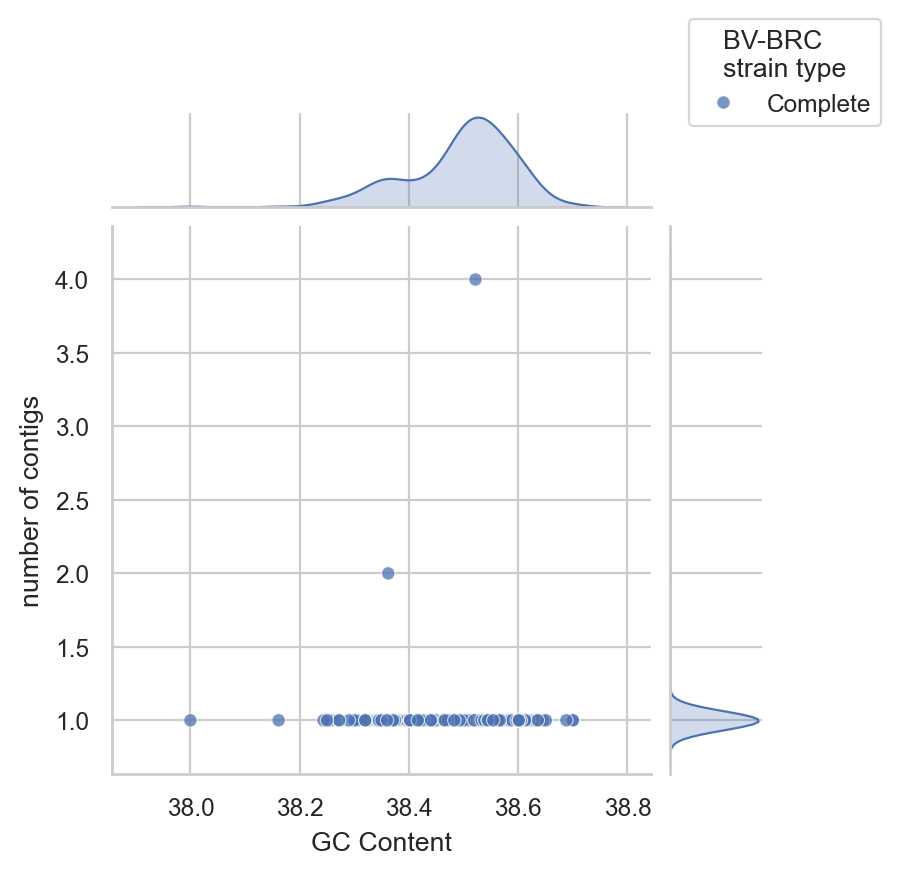

In [11]:
# Ensure GC content makes sense
# Remove any big outliers
# (in this case nothing needs filtering)

h = sns.jointplot(
    data=filtered_species_summary,
    x="gc_content",
    y="contigs",
    hue="genome_status",
    alpha=0.75,
    height=4
)

h.ax_joint.legend(
    title='BV-BRC\nstrain type',
    bbox_to_anchor=(1.45,1.4)
)

h.ax_joint.set_xlabel("GC Content")
h.ax_joint.set_ylabel("number of contigs")
plt.show()

In [12]:
filtered_species_metadata = metadata.loc[filtered_species_summary.index]
filtered_species_metadata

,genome_id,genome_name,organism_name,taxon_id,genome_status,strain,serovar,biovar,pathovar,mlst,...,motility,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease,comments,additional_metadata
637182,1314.4070,Streptococcus pyogenes 1004,NaN,1314,Complete,1004,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure culture
637183,1314.4068,Streptococcus pyogenes 1039,NaN,1314,Complete,1039,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure culture
637184,1314.4067,Streptococcus pyogenes 1042,NaN,1314,Complete,1042,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure culture
637185,1314.4071,Streptococcus pyogenes 1044,NaN,1314,Complete,1044,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure culture
637186,1314.3939,Streptococcus pyogenes 1095,NaN,1314,Complete,1095,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.530,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sample_type:Pure cultured organism;biomaterial...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639438,1314.1009,Streptococcus pyogenes strain emmNA,NaN,1314,Complete,emmNA,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete genomes of 30 globally distributed Gr...,collected_by:Davies_et_al
639439,1314.994,Streptococcus pyogenes strain emmSTG866.1,NaN,1314,Complete,emmSTG866.1,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.450,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete genomes of 30 globally distributed Gr...,collected_by:Davies_et_al
639455,1314.2849,Streptococcus pyogenes strain iGAS376,NaN,1314,Complete,iGAS376,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete genomes of three invasive isolates of...,"collected_by:Scottish Haemophilus, Legionella,..."
639456,1314.2850,Streptococcus pyogenes strain iGAS391,NaN,1314,Complete,iGAS391,NaN,NaN,NaN,MLST.Streptococcus_pyogenes.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Complete genomes of three invasive isolates of...,"collected_by:Scottish Haemophilus, Legionella,..."


## Save (first-pass) filtered genome info files for download

In [13]:
filtered_species_summary.to_pickle('data/interim/genome_summary_1a.pickle')
filtered_species_metadata.to_pickle('data/interim/genome_metadata_1a.pickle')

In [14]:
df_filtration.to_pickle('data/interim/df_filtration_1a.pickle')